In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus 
from IPython.display import Image 
from collections import Counter

In [2]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [3]:
# Starting datasets
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df_customer = pd.read_csv('datasets/customer_dataframe_big.csv', sep='\t', index_col=0)

df_customer.set_index("CustomerID", inplace = True)
df_customer['Label'] = df['Label']
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MaxPO           4333 non-null   int64  
 3   MinPO           4333 non-null   int64  
 4   MeanProdOrder   4333 non-null   float64
 5   TSale           4333 non-null   float64
 6   TSaleWRet       4333 non-null   float64
 7   MinPSale        4333 non-null   float64
 8   MaxPSale        4333 non-null   float64
 9   MeanSaleOrder   4333 non-null   float64
 10  TRProd          4333 non-null   int64  
 11  MeanPSale       4333 non-null   float64
 12  TOrder          4333 non-null   int64  
 13  OrderMonth      4333 non-null   float64
 14  ProdMonth       4333 non-null   float64
 15  SaleMonth       4333 non-null   float64
 16  SETSaleQta      4333 non-null   float64
 17  SESaleQtaOrder  4333 non-nul

In [4]:
df_customer = discretize_data(df_customer,['MaxOrderMonth','Label'])

In [5]:
df_aux = df_customer.drop(columns=['TSaleWRet', 'MaxOrderMonth', 'Label', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale', 'SETSaleQta', 'SESaleQtaOrder', 'MaxPO', 'MinPO', 'MinPSale', 'MaxPSale'], errors='ignore')
df_class = df_aux.copy()
df_class.tail()

,TProd,DProd,TSale,TRProd,TOrder,OrderMonth,ProdMonth,SaleMonth,MonthPresence,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,,,,,
13436,76,12,196.89,0,1,0.083,6.333,16.407,0.083,2,1
15520,314,18,343.50,0,1,0.083,26.167,28.625,0.083,2,1
13298,96,2,360.00,0,1,0.083,8.000,30.000,0.083,2,1
14569,79,10,227.39,0,1,0.083,6.583,18.949,0.083,2,1
12713,505,37,794.55,0,1,0.083,42.083,66.212,0.083,2,2


# Decision Tree

In [6]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify =label, test_size=0.30)

In [7]:
print(f"Class HighSpend\nTrain: {len(train_label[train_label == 0])}\nTest: {len(test_label[test_label == 0])}")

Class HighSpend
Train: 18
Test: 8


In [8]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=30, min_samples_leaf=5)
dt = dt.fit(train_set, train_label)

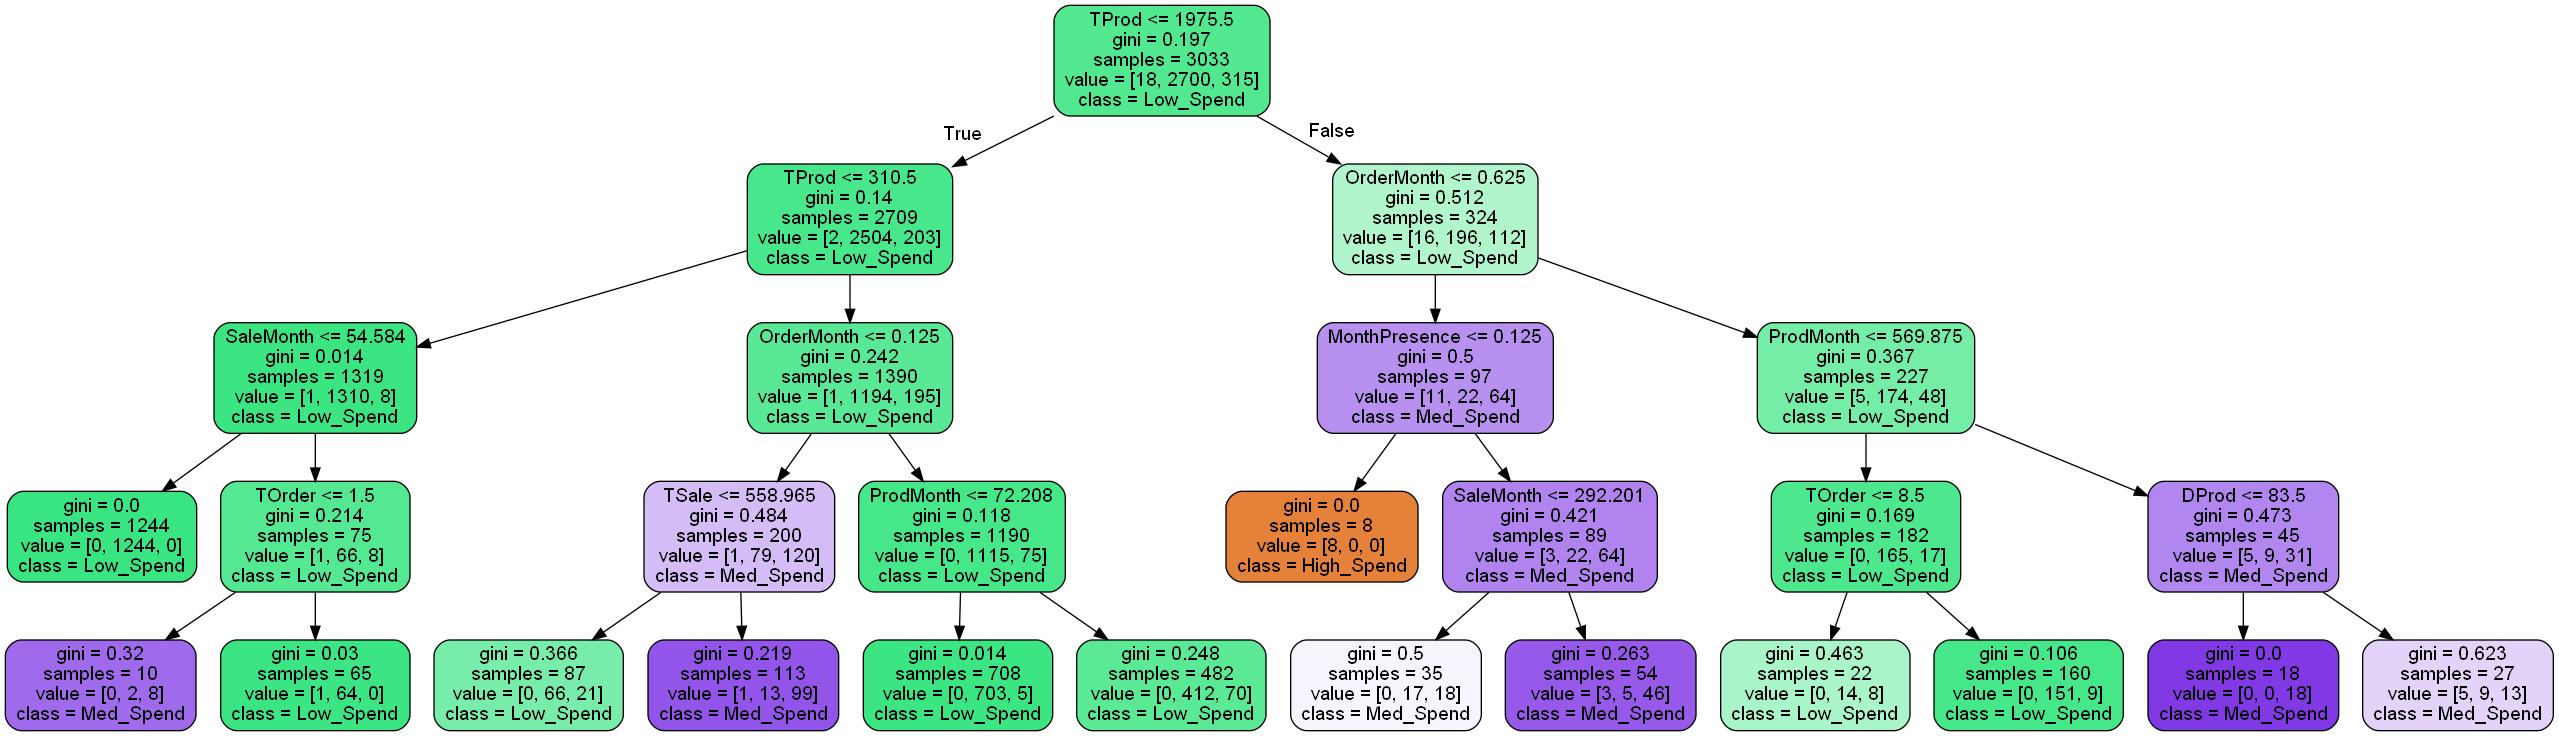

In [9]:
#visualize the actual decision tree obtained  
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [10]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [11]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9442795911638642
Accuracy test set  0.9161538461538462
Precision train set  0.9411104934628468
Recall train set  0.9442795911638642
F1 score train set  0.9411652884461498
Support train set  (array([1.        , 0.95881503, 0.78599222]), array([0.44444444, 0.98296296, 0.64126984]), array([0.61538462, 0.97073884, 0.70629371]), array([  18, 2700,  315], dtype=int64))


In [12]:
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=classes))

In [13]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.67      0.25      0.36         8
   Low_Spend       0.94      0.97      0.96      1157
   Med_Spend       0.62      0.50      0.56       135

    accuracy                           0.92      1300
   macro avg       0.74      0.57      0.63      1300
weighted avg       0.91      0.92      0.91      1300



***